#### Datos
Los datos del interferómetro vienen almacenados en un archivo de formato rad. Antes de abrir los datos en python, es importante notar que los números utilizan comas (,) en vez de puntos (.). Esto genera problemas en la lectura, por lo que se recomienda abrir el archivo con algun editor de texto y reemplazar las comas por puntos. La mayoría de los editores de texto poseen una funcion para esto (replace). Se recomienda el editor Sublime Text.

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import hilbert
from scipy.special import j1
from scipy.optimize import curve_fit

In [124]:
!git clone https://github.com/amaliamartinez-netizen/interferometria

fatal: destination path 'interferometria' already exists and is not an empty directory.


In [125]:
path="/content/interferometria/Datos_interferometria (1).rad"

ds = np.genfromtxt(path, comments="*") # set de datos leidos por numpy, extraidos desde 'interferometría.rad'

Ahora es importante extraer los datos. Según el enunciado, la organización de los mismos es como sigue. Los datos corresponden a una matriz de 18979 filas y 73 columnas. Cada fila es un dato. Cada columna almacena la siguiente información en el mismo orden:

| col 1  | col 2  |col 3  |col 4 | col 5  |     col 6    |    col 7     | col 8 |      col 9       |cols 10-73(64)|
|--------|--------|-------|------|--------|--------------|--------------|-------|------------------|--------------|
|Hora UTC| Azimut |Elevaci|  0   |   0    |Frec ini (MHz)|Tam C.E. (MHz)|   1   |$N^o$ Canales (64)| Canales  (T) |

De toda la información, nos interesa rescatar los canales (los cuales almacenan temperatura), la elevación y el azimut.

In [126]:
Channels = ds[:, 9:] # 18k mediciones, con 64 canales por medicion (matriz de 18k x 64)
Azimut = ds[:, 1] # azimut por medicion (vector de largo 18k)
Elevac = ds[:, 2] # elevacion por medicion (vector de largo 18k)

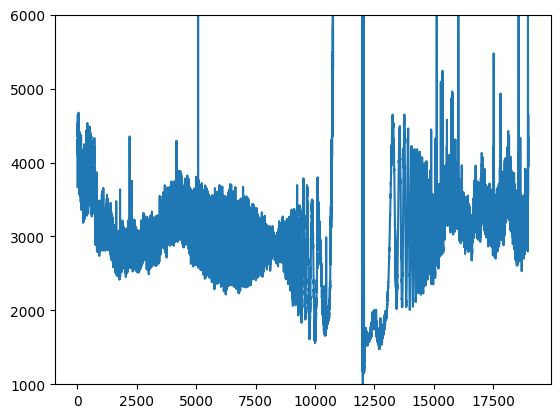

In [127]:
# promediar canales
Channels=np.mean(Channels, axis=1)
plt.plot(Channels)
plt.ylim(1000, 6000)
plt.show()

In [128]:
path="/content/interferometria/datos mañana.txt"

mañana = np.genfromtxt(path, comments="*")

In [129]:
ChannelsAM = mañana[:, 9:] # 18k mediciones, con 64 canales por medicion (matriz de 18k x 64)
AzimutAM = mañana[:, 1] # azimut por medicion (vector de largo 18k)
ElevacAM = mañana[:, 2] # elevacion por medicion (vector de largo 18k)

In [130]:
ChannelsAM=np.mean(ChannelsAM, axis=1)

In [131]:
ChannelsAM[0]= 3000
for i in range(len(ChannelsAM)):
  if ChannelsAM[i]>= 4500:
    ChannelsAM[i] = ChannelsAM[i-1]

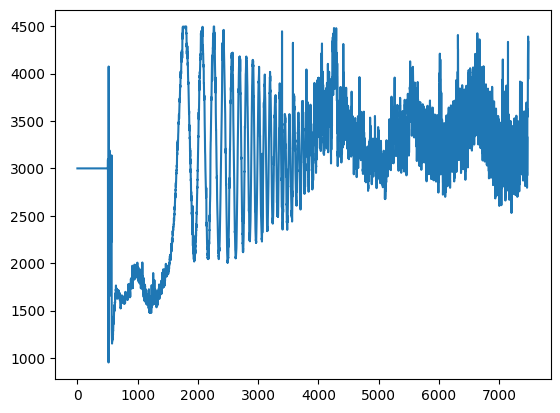

In [132]:

plt.plot(ChannelsAM)
#plt.ylim(1000, 6000)
plt.show()

In [133]:
def local_norm(y, N):
    y2 = y
    for i in range(N, len(y) - N - 1):
        y_local = y2[i - N : i + N]
        if y2[i] >= max(y_local) or y2[i] <= min(y_local):
            y2[i] = 0.5*(y_local[0] + y_local[N - 1])
    return y2
y_2 = local_norm(ChannelsAM, 2000)

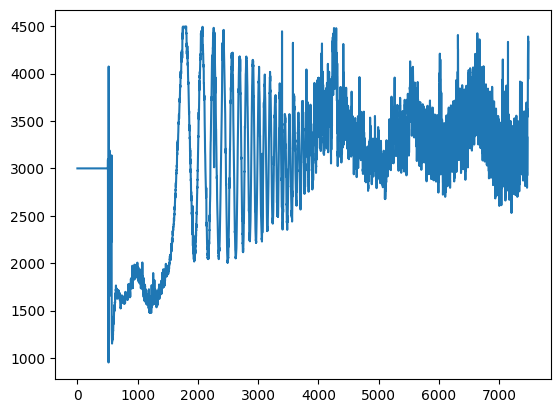

In [134]:
plt.plot(y_2)

plt.show()

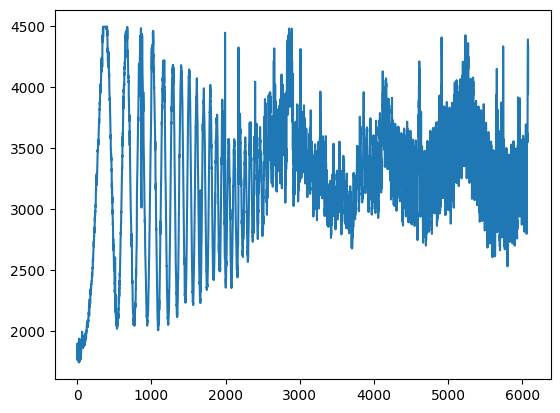

In [135]:
def filtro_elevacion_G(elevations, data, az, elevation_threshold=15, window_size=51):

    processed_data = data.copy()

    mask_to_keep = elevations >= elevation_threshold

    cleaned_data = processed_data[mask_to_keep]
    cleaned_azimut = az[mask_to_keep]
    cleaned_elevations = elevations[mask_to_keep]
    return cleaned_data, cleaned_azimut, cleaned_elevations

chan_filtrado, cleaned_Az, cleaned_El=filtro_elevacion_G(ElevacAM, ChannelsAM, AzimutAM)
plt.plot(chan_filtrado)
plt.show()

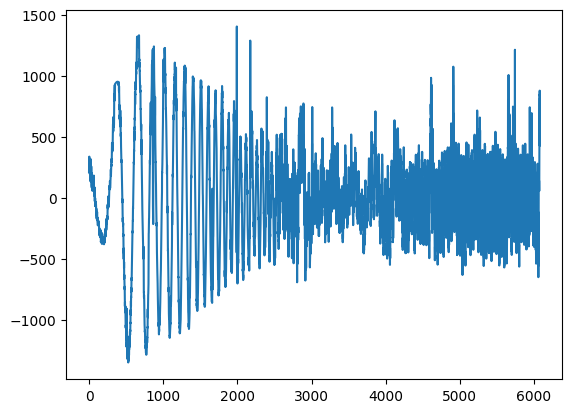

In [136]:
def remover_periodos_largos(flux, window_frac=0.1, polyorder=3):

    n = len(flux)
    window = int(window_frac * n)

    # La ventana debe ser impar
    if window % 2 == 0:
        window += 1

    # Filtro suave = tendencia
    trend = savgol_filter(flux, window_length=window, polyorder=polyorder)

    # Señal libre de variaciones largas
    detrended_flux = flux - trend

    return detrended_flux


def remove_dc(flux):
    output = flux - np.mean(flux)
    return output

AM_filtrado = remover_periodos_largos(chan_filtrado)
AM_filtrado = remove_dc(AM_filtrado)
plt.plot(AM_filtrado)
plt.show()

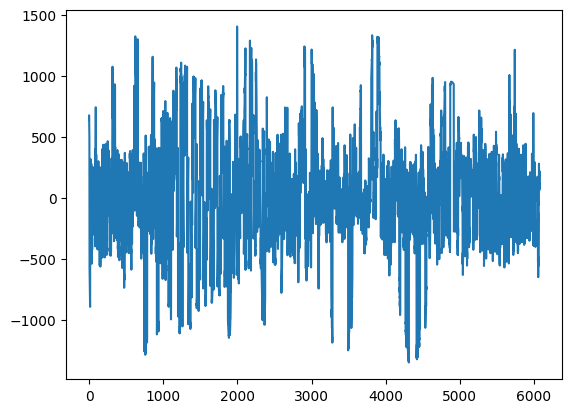

In [137]:
def ordenar_bs(az, el, data, B_az=85.2, b=37.85):
    B_az=np.deg2rad(B_az)
    b=np.deg2rad(b)
    az = np.deg2rad(az)
    el = np.deg2rad(el)

    s_e = np.cos(el) * np.sin(az)   # componente East
    s_n = np.cos(el) * np.cos(az)   # componente North
    s_u = np.sin(el)                # componente Up
    s_hat = np.stack([s_e, s_n, s_u], axis=-1)

    B_vec = b * np.array([np.sin(B_az), np.cos(B_az), 0.0])
    Bs = b * (np.sin(B_az) * s_e + np.cos(B_az) * s_n)

    # Ordenar
    orderb = np.argsort(Bs)
    orderd = np.argsort(np.linalg.norm(s_hat[orderb], axis=-1))
    Bs_sorted = Bs[orderb]
    data_sorted = data[orderd]

    return data_sorted, Bs_sorted

chan_ordenado, Bs_ord_AM=ordenar_bs(cleaned_Az, cleaned_El, AM_filtrado)
plt.plot(chan_ordenado)
plt.show()

In [138]:
path="/content/interferometria/datos tarde.txt"

tarde = np.genfromtxt(path, comments="*")

In [139]:
ChannelsPM = tarde[:, 9:] # 18k mediciones, con 64 canales por medicion (matriz de 18k x 64)
AzimutPM = tarde[:, 1] # azimut por medicion (vector de largo 18k)
ElevacPM = tarde[:, 2] # elevacion por medicion (vector de largo 18k)

In [140]:
ChannelsPM=np.mean(ChannelsPM, axis=1)

In [141]:
ChannelsPM[0]= 3000
for i in range(len(ChannelsPM)):
  if ChannelsPM[i]>= 4500:
    ChannelsPM[i] = ChannelsPM[i-1]

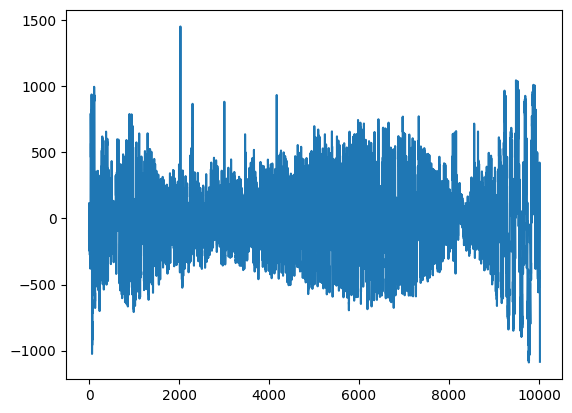

In [142]:
filtro1 =local_norm(ChannelsPM, 2000)
filtro2, AzimutPM, ElevacPM = filtro_elevacion_G(ElevacPM, filtro1, AzimutPM)
filtro3=remover_periodos_largos(filtro2)
filtro4=remove_dc(filtro3)
chan_ordenado2, Bs_ord_PM=ordenar_bs(AzimutPM, ElevacPM, filtro4)

plt.plot(chan_ordenado2)
plt.show()

In [143]:
def visibility_model(Bs, theta, A, lamb=0.211):
    x = np.pi * Bs * theta / lamb
    # evitar división por cero
    x = np.where(x == 0, 1e-12, x)
    V = A * (2 * j1(x) / x)
    return np.abs(V)

In [144]:
def extract_envelope(signal):
    analytic = hilbert(signal)
    envelope = np.abs(analytic)
    return envelope

In [145]:
def fit_visibility(Bs, envelope, lamb=0.211):
    # Estimaciones iniciales:
    # θ ~ 0.0093 rad ~ 32 arcmin
    theta0 = np.deg2rad(32 / 60)
    A0 = np.max(envelope)

    p0 = [theta0, A0]

    popt, pcov = curve_fit(
        lambda Bs, theta, A: visibility_model(Bs, theta, A, lamb=lamb),
        Bs, envelope, p0=p0, maxfev=10000
    )

    return popt, pcov


In [146]:
def first_zero(theta, lamb=0.211):
    x0 = 3.8317
    Bs0 = x0 * lamb / (np.pi * theta)
    return Bs0

In [147]:
def Estimacion(Bs, data, lamb=0.211, plot=True):

    envelope = extract_envelope(data)

    popt, pcov = fit_visibility(Bs, envelope, lamb=lamb)
    theta_fit, A_fit = popt

    Bs_zero = first_zero(theta_fit, lamb=lamb)

    theta_arcmin = theta_fit*10800/np.pi

    if plot:
        Bs_model = np.linspace(Bs.min(), Bs.max(), 2000)
        V_model = visibility_model(Bs_model, theta_fit, A_fit, lamb=lamb)

        plt.figure(figsize=(10,6))
        plt.plot(Bs, envelope, '.', label="Envolvente experimental", alpha=0.6)
        plt.plot(Bs_model, V_model, 'r-', label="Ajuste modelo disco uniforme")
        #plt.axvline(Bs_zero, color='k', ls='--',
                    #label=f"Primer cero Bs = {Bs_zero:.3f} m")
        plt.xlabel("B_s [m]")
        plt.ylabel("Amplitud")
        plt.title(f"Diámetro angular solar = {theta_arcmin:.2f} arcmin")
        plt.legend()
        plt.grid()
        plt.show()

    return theta_fit, theta_arcmin, Bs_zero

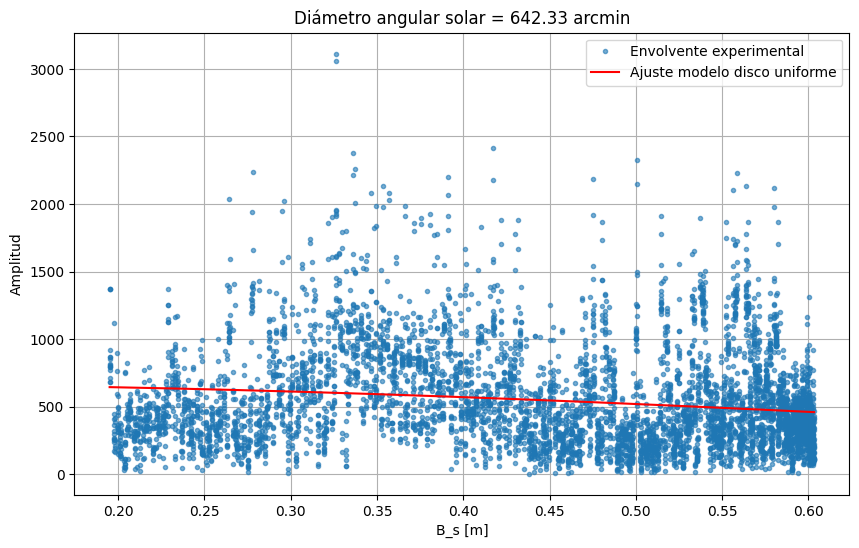

θ (rad)     = 0.18684567002831048
θ (arcmin)  = 642.3280987749728
Primer cero = 1.3773396302889318 m


In [148]:
theta_rad, theta_arcmin, Bs0 = Estimacion(Bs_ord_AM, chan_ordenado)

print("θ (rad)     =", theta_rad)
print("θ (arcmin)  =", theta_arcmin)

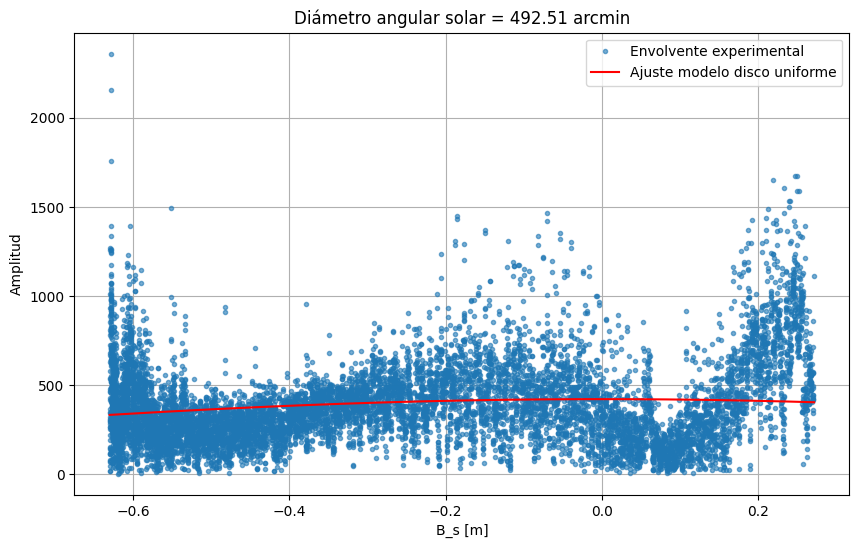

θ (rad)     = 0.14326645834043056
θ (arcmin)  = 492.5138045216102
Primer cero = 1.796302840587882 m


In [149]:
theta_rad, theta_arcmin, Bs0 = Estimacion(Bs_ord_PM, chan_ordenado2)

print("θ (rad)     =", theta_rad)
print("θ (arcmin)  =", theta_arcmin)